<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="ffffff">
base code

</font>
</h1>

pariya branch

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display
import sys
import pandas as pd
from keras.layers import Activation, Dense
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Sequential
from keras.layers import BatchNormalization

In [23]:
!pip install efficientnet


In [24]:

base_model = tf.keras.applications.VGG16(weights="imagenet",
    input_shape=(100, 100, 3),
    include_top=False)

vgg_layer_list = base_model.layers

base_model = keras.Sequential()

for i in range(len(vgg_layer_list)-1):
   base_model.add(vgg_layer_list[i])

In [26]:
base_model.trainable = False
base_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 25, 25, 256)      

In [36]:

model.compile(optimizer='adam', loss = "categorical_crossentropy" , metrics =['accuracy'])

In [32]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_ds_ = train_datagen.flow_from_directory(
    r'E:\projectDataset\archive\sl_train',
    class_mode='categorical',
    target_size=(100,100),
    shuffle=True,
    batch_size=32
)


test_datagen = ImageDataGenerator(rescale=1./255)

test_ds_ = test_datagen.flow_from_directory(
    r'E:\projectDataset\archive\sl_test',
    class_mode='categorical',
    target_size=(100,100),

    batch_size=32
)


#
val_datagen = ImageDataGenerator(rescale=1./255)

val_ds = val_datagen.flow_from_directory(
    r'E:\projectDataset\archive\sl_valid',
    class_mode='categorical',
    target_size=(100,100),
    shuffle=True,
    batch_size=32
)



Found 2907 images belonging to 12 classes.
Found 1166 images belonging to 12 classes.
Found 1420 images belonging to 12 classes.


In [38]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping2_acc = EarlyStopping(
    min_delta=0.0001,
    patience=5,
    monitor="accuracy",
    restore_best_weights=True,
    mode="auto"
)

early_stopping2_loss = EarlyStopping(
    min_delta=0.0001,
    patience=5,
    monitor="loss",
    restore_best_weights=True,
    mode="auto"
)

history2 = model.fit(
    train_ds_,
    batch_size = 32,
    epochs = 5,
    
    validation_data= val_ds,
    callbacks = [early_stopping2_acc, early_stopping2_loss]
    )
    

Epoch 1/5
91/91 [==============================] - 169s 2s/step - loss: 1.0961 - accuracy: 0.6058 - val_loss: 0.5930 - val_accuracy: 0.8085
Epoch 2/5
91/91 [==============================] - 151s 2s/step - loss: 0.6809 - accuracy: 0.7451 - val_loss: 0.4569 - val_accuracy: 0.8479
Epoch 3/5
91/91 [==============================] - 154s 2s/step - loss: 0.5845 - accuracy: 0.7788 - val_loss: 0.5149 - val_accuracy: 0.8359
Epoch 4/5
91/91 [==============================] - 155s 2s/step - loss: 0.4541 - accuracy: 0.8338 - val_loss: 0.4372 - val_accuracy: 0.8556
Epoch 5/5
91/91 [==============================] - 157s 2s/step - loss: 0.4350 - accuracy: 0.8449 - val_loss: 0.4131 - val_accuracy: 0.8676


In [43]:
model.save('../models/1fruit_disease_classifier_vgg16.h5')

In [44]:
test_loss, test_accuracy = model.evaluate(test_ds_, steps=len(test_ds_)/32)
print('Accuracy on test dataset:', test_accuracy)

1/1 [==============================] - 3s 10s/step - loss: 1.7546 - accuracy: 0.7188                  
Accuracy on test dataset: 0.71875


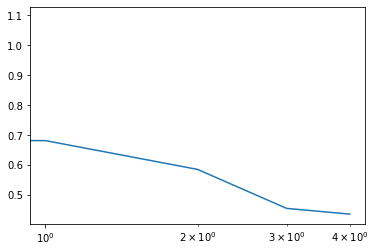

In [45]:
import matplotlib.pyplot as plt

plt.semilogx( history2.history["loss"])

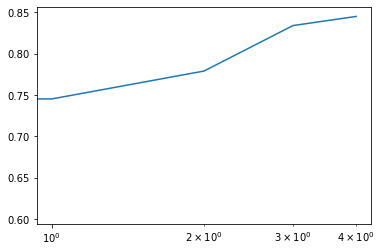

In [46]:
plt.semilogx( history2.history["accuracy"])